In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from math import sqrt
%matplotlib inline

In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [ ]:
chars = sorted(list(set(''.join(words))))
stio = {s:i+1 for i,s in enumerate(chars)}
stio['.']=0
iots = {i:s for s,i in stio.items()}
print(iots)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
#building dataset
block_size = 3
X, Y = [],[]

for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w +'.':
        ix = stio[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(iots[i] for i in context),'---->',iots[ix])
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, X.dtype, Y.shape,Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
c =torch.randn((27,2))
emb = c[X]
emb.shape

torch.Size([228146, 3, 2])

In [ ]:
W1 = torch.randn((6,100))*(5/3)*sqrt(3/6)
b1 = torch.randn(100)

In [ ]:
#emb.view(emb.shape[0],6)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [ ]:
h.mean(),h.std()

(tensor(-0.0499), tensor(0.8739))

the W1 dimention is determined by the inputs;Here we have 2 dimentinal embedding with 3 inputs(charcters).  
So the W1 will be (3x2=6), then the second dim is our parameter of how many neurons we want, lets say 100.  
* but if we simply multiply(dot product) the emb(shape[32,3,2]) with W1(shape[6,100]), we will get an error.
concaticating the embedding inputs is needed. 
- we can use pytorch for this.

In [ ]:
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (684438x2 and 6x100)

In [ ]:
#but this restrict as in changing the block size easily
torch.cat([emb[:,0,:],emb[:,1,:], emb[:,2,:]],1).shape

torch.Size([228146, 6])

In [ ]:
# torch unbind lets us easily change the blocksize and dont hardcode it
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([228146, 6])

In [ ]:
a =torch.arange(18);a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
a.view(6,3)

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]])

- the internal storage of memory of the variable is unchanged when we call .view just the attributes
 refer is article [http://blog.ezyang.com/2019/05/pytorch-internals/]

In [ ]:
a.storage()

/var/folders/33/syn88g8j53n7x_0ysjcp508w0000gn/T/ipykernel_35491/214256462.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

- emb.view(32,6) == torch.cat(torch.unbind(emb,1),1)
it gives us the same result

In [ ]:
#emb.view(emb.shape[0],6)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [ ]:
h.mean(),h.std()

(tensor(-0.0499), tensor(0.8739))

In [ ]:
h.shape

torch.Size([228146, 100])

In [ ]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [ ]:
counts = logits.exp()

sum(keepdims=True)... is for not making braodcasting bug, adds dimention size 1 axes (27,1)  
* coz broadcating starts from rigth to left so (27) is changed to as (1,27), keepdims addes trailing size one axes

In [ ]:
probs = counts / counts.sum(1,keepdims=True) # .exp and normalizing by sum gives us softmax

In [ ]:
loss = -probs[torch.arange(32),Y].log().mean() #nll
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [ ]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

## --------!-----!---

In [ ]:
def build_dataset(words):
    
    block_size = 3
    X, Y = [],[]

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w +'.':
            ix = stio[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(iots[i] for i in context),'---->',iots[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xts, Yts = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
Xtr.shape,Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

* number of hidden embedding size, fastai Jeremy right hand rule
round(1.6 * number of categories * 0.56 # number of categories here = vocab_size

In [ ]:
n_dim = 10 # embedding dimention size
bs = 32 # batch size
B = 3 # block size
n_hidden = 200
vocab_size =27

g= torch.Generator().manual_seed(2147483647)
C =torch.randn((vocab_size,n_dim),generator=g)
W1 = torch.randn(((n_dim*B),n_hidden),generator=g) * (5/3)/((n_dim*B)**0.5)
b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),generator=g)* 0.01
b2 = torch.randn(vocab_size,generator=g)*0.01

bnrmg = torch.ones(1,n_hidden)
bnrmb = torch.zeros(1,n_hidden)
bnrmean_running = torch.ones(1,n_hidden)
bnrstd_running = torch.ones(1,n_hidden)

parameters = [C,W1,b1,W2,b2, bnrmg, bnrmb]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

12297


In [ ]:
W1.mean(),W1.std()

(tensor(0.0039, grad_fn=<MeanBackward0>),
 tensor(0.3107, grad_fn=<StdBackward0>))

F.cross_entropy is much more efficient in calculating, in backpropagations and offseting the max number for (preventing out of computer floating point reach)

- minibatch = instead of optimizing on the whole dataset at one time we can optimize on a small dataset(minibatches) to make it faster... but the gradient is just an approximate as it is not operating on the whole dateset but still good enough
- torch.randint(0,X.shape[0], (32,))

In [ ]:
# lre = torch.linspace(-3,0,1000)
# lrs = 10**lre


In [ ]:
lri,lossi,stepi =[],[],[]

In [ ]:
max_steps = 200000

for i in range(max_steps):
    #contruct a minibatch
    ix = torch.randint(0,Xtr.shape[0], (bs,))
    xb,yb = Xtr[ix],Ytr[ix]
    
    #forward pass
    emb = C[xb] # 32,3,2
    emb_cat = emb.view(emb.shape[0],(n_dim*B))
    hpre_act = emb_cat @ W1 + b1
    #batchnormalization
    bnrmean = hpre_act.mean(0,keepdims=True)
    bnrstd = hpre_act.std(0,keepdims=True)
    hpre_act = bnrmg*(hpre_act - bnrmean)/bnrstd + bnrmb
    
    with torch.no_grad():
        bnrmean_running = 0.999 * bnrmean_running + 0.001 *bnrmean
        bnrstd_running = 0.999 * bnrstd_running + 0.001 * bnrstd
        
    h = torch.tanh(hpre_act) # 32,200
    logits = h @ W2 + b2 # 32,27
    loss = F.cross_entropy(logits,yb)
    #print(loss.item())
    
    #backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #updating
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    #tracking stats
    if i %10000==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.2731
  10000/ 200000: 2.2755
  20000/ 200000: 2.3808
  30000/ 200000: 2.6572
  40000/ 200000: 2.2067
  50000/ 200000: 2.0507
  60000/ 200000: 2.2804
  70000/ 200000: 1.9859
  80000/ 200000: 2.0361
  90000/ 200000: 2.2200
 100000/ 200000: 2.4013
 110000/ 200000: 2.2786
 120000/ 200000: 2.0969
 130000/ 200000: 2.2766
 140000/ 200000: 1.8825
 150000/ 200000: 2.0989
 160000/ 200000: 2.1229
 170000/ 200000: 1.8012
 180000/ 200000: 2.0921
 190000/ 200000: 2.5638


<matplotlib.image.AxesImage>

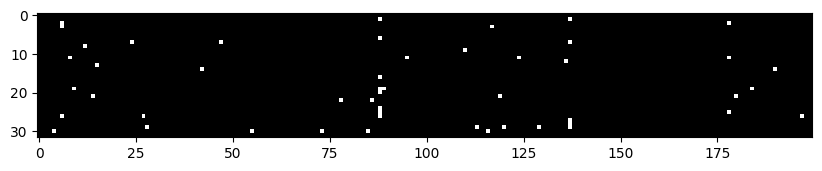

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(h.abs()>0.999, cmap ='gray', interpolation= 'nearest') # white color indicates true boolian (dead activation on the flat tail of tanh)

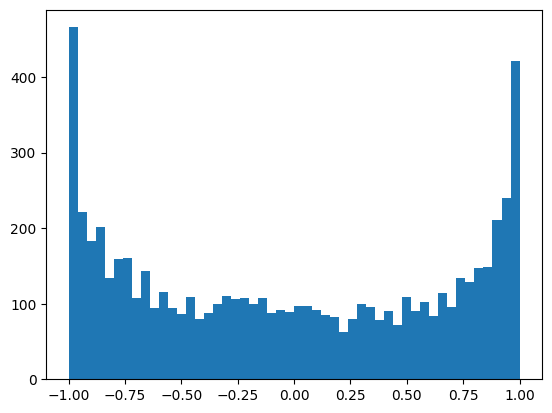

In [ ]:
plt.hist(h.view(-1).tolist(),50);

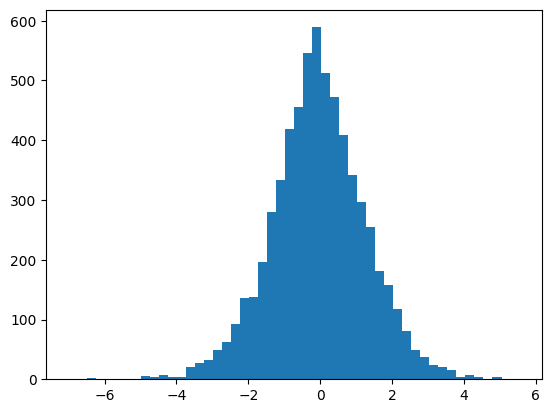

In [ ]:
plt.hist(hpre_act.view(-1).tolist(),50);

#### The expected nll loss/ probability of our network at the start can be calculated here, all the 27 vocab should have equal probability of being the next word

In [ ]:
-torch.tensor(1/vocab_size).log()

tensor(3.2958)

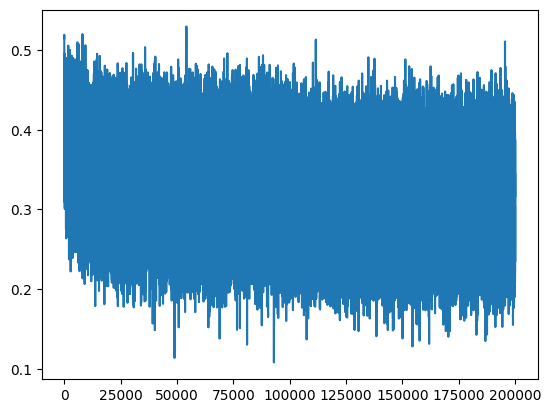

In [ ]:
plt.plot(lossi);

In [ ]:
#caliberating batchnoram at the end of training
with torch.no_grad():
    emb = C[Xtr] # 32,3,2
    emb_cat = emb.view(emb.shape[0],(n_dim*B))
    hpre_act = emb_cat @ W1 + b1
    #measure the mean &std over the entire training set
    bnrm = hpre_act.mean(0,keepdims=True)
    bnrst = hpre_act.std(0, keepdims=True)


In [ ]:
# test data loss test
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'dev': (Xdev,Ydev),
        'test': (Xts, Yts)
    }[split]
    
    emb = C[x] # 32,3,2
    emb_cat = emb.view(emb.shape[0],(n_dim*B))
    hpre_act = emb_cat @ W1 + b1
    #batchnormalization
    #hpre_act = bnrmg*(hpre_act - hpre_act.mean(0,keepdims=True))/hpre_act.std(0,keepdims=True) + bnrmb
    hpre_act = bnrmg*(hpre_act - bnrmean_running)/bnrstd_running + bnrmb
    h = torch.tanh(hpre_act) # 32,200
    logits = h @ W2 + b2 # 32,27
    loss = F.cross_entropy(logits,y)
    print(f'{split} {loss.item():.4f}')

split_loss('train')
split_loss('dev')

train 2.0690
dev 2.1107


best score so far = tr_loss-->2.1088, dev -->2.1544 , tst --> 2.1637 # 400 neurons/activations  
...........................-->2.0126, dev -->2.1036,  tst --> 2.0921 # kaiming activation   
...........................-->2.0365, dev -->2.1014, # proper kaiming activation  
...........................-->2.0688, dev -->2.1114, # batchnormalization  
best score so far = tr_loss-->2.1141, dev -->2.1637  
neurons size of 300 .......-->2.0969, dev -->2.1647  
emb size = 5...............-->2.1680, dev -->2.1964  

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(),iots[i], ha='center', va='center', color='white')
plt.grid('minor')

In [ ]:
plt.plot(lri,lossi)# this plot can give as the rough estimate of the good lr

In [ ]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 11)

for _ in range(20):
    out = []
    context = [0]* block_size # initializing all with ...
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, 1)
        ix = torch.multinomial(probs, num_samples=1, generator =g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix ==0:
            break
            
    print(''.join(iots[i] for i in out ))
        